## Часть 1
Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или Arrow, постройте график числа сообщений в зависимости от даты. 

In [1]:
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_context("notebook")
sns.set_style("whitegrid")

In [2]:
with open("../data/messages.json", 'r', encoding ='utf-8') as file:
    messages = json.load(file)

In [3]:
offset = datetime.timedelta(hours=3)
tz = datetime.timezone(offset, name='МСК')

In [4]:
df = pd.DataFrame(messages)
df['date'] = pd.to_datetime(df['date']).dt.tz_convert(tz).dt.tz_localize(None)
df['time'] = df['date'].dt.time
df['date'] = df['date'].dt.date
df['message'] = df['message'].replace({"": None})
df = df.dropna()
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21677 entries, 0 to 23363
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       21677 non-null  int64 
 1   date     21677 non-null  object
 2   from_id  21677 non-null  int64 
 3   message  21677 non-null  object
 4   time     21677 non-null  object
dtypes: int64(2), object(3)
memory usage: 1016.1+ KB


,id,date,from_id,message,time
23359,136674,2021-12-18,289415351,"Ж, 29, АИТ, гипотиреоз, приём рексетина (трево...",12:50:34
23360,136675,2021-12-18,1170598440,Дополняю.\n16.12.2021 V2 \nСначала было сверх ...,13:20:44
23361,136676,2021-12-18,551284288,Ж53. Болела год назад. За неделю до лайта 387 ...,14:30:28
23362,136677,2021-12-18,1522409953,Народные отчеты о вакцинации\n\n⚠️ ТОЛЬКО ПУБЛ...,15:00:04
23363,136679,2021-12-18,1522409953,🔘 Приглашаем принять участие в КИ 🐰\n\n1️⃣🧒 КИ...,16:15:02


In [5]:
df.from_id.value_counts().head(6)

1060884316    540
411259144     354
609983163     231
915878674     173
321348666     131
430829243      57
Name: from_id, dtype: int64

In [6]:
df[df.from_id == 915878674].head()

,id,date,from_id,message,time
4349,32916,2021-01-27,915878674,Ж40. Без хронических болезней. V1 24.10.2020 н...,20:33:36
7045,60648,2021-02-14,915878674,Update 13.02.21 113 дней 07-206 Хеликс АТ 72.2,00:47:12
11225,90924,2021-03-28,915878674,Update: 155 день 64.8 Diasorin,09:52:06
12696,103274,2021-04-25,915878674,183 день Эббот и Диасорин,17:57:32
13543,110772,2021-05-20,915878674,"Укажите, пожалуйста, даты прививок",07:38:46


у кого много сообщений - админы - пересылают сообщения из других чатов, а еще пишут сообщения о том, что нельзя общаться

всякие инфопосты в выборку не попали, фото и другое отбросили

### Часть 2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательная визуализация. 

In [7]:
# sex_age_reg = "([МЖ])[, ]*(\d+(?!\d*.\d))|(\d+)[, ]*([МЖ])[^\w]"
sex_age_reg = "([МЖ])[, ]*(\d+(?!\d*.\d))"

def find_sex_age(s):
    match = re.findall(sex_age_reg, s, flags=re.MULTILINE)
    sex, age = None, None
    if match:
        sex, age = match[0]
        age = int(age)
    return [sex, age]

matches = df.message.apply(find_sex_age).values

df['sex'] = [i[0] for i in matches]
df['age'] = [i[1] for i in matches]

In [8]:
def find_score(s):
    s = s.lower()
    matches = [re.findall(f"(\d+|\d+[,.]\d*)\s*({reg})", s, flags=re.MULTILINE) for reg in ["bau", "ое|oe", "au|ae", "ед"]]
    scores = {
        "BAU/ml": None,
        "OE/ml": None,
        "AU/ml": None,
        "ед/мл": None,
    }
    for match, key in zip(matches, scores.keys()):
        if match is not None and match:
            # print(match)
            score, _ = match[-1]
            score = float(score.replace(',', '.'))
            scores[key] = score
    return scores

scores = pd.DataFrame(df.message.apply(find_score).values.tolist())
for col in scores.columns:
    df[col] = scores[col]
scores_cols = scores.columns

def transform_scores(df):
    df = df.copy()
    df["ед/мл"] = df["ед/мл"] / 7
    df["OE/ml"] = 2.6 * df["OE/ml"]
    df["AU/ml"] = df["AU/ml"] / 7
    df = df.fillna(method='bfill', axis=1)
    return df["BAU/ml"]
df["Score"] = transform_scores(df[scores_cols])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21677 entries, 0 to 23363
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       21677 non-null  int64  
 1   date     21677 non-null  object 
 2   from_id  21677 non-null  int64  
 3   message  21677 non-null  object 
 4   time     21677 non-null  object 
 5   sex      13719 non-null  object 
 6   age      13719 non-null  float64
 7   BAU/ml   733 non-null    float64
 8   OE/ml    614 non-null    float64
 9   AU/ml    156 non-null    float64
 10  ед/мл    359 non-null    float64
 11  Score    1537 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.1+ MB


In [9]:
df.reset_index(drop=True).to_feather("../data/messages.feather")

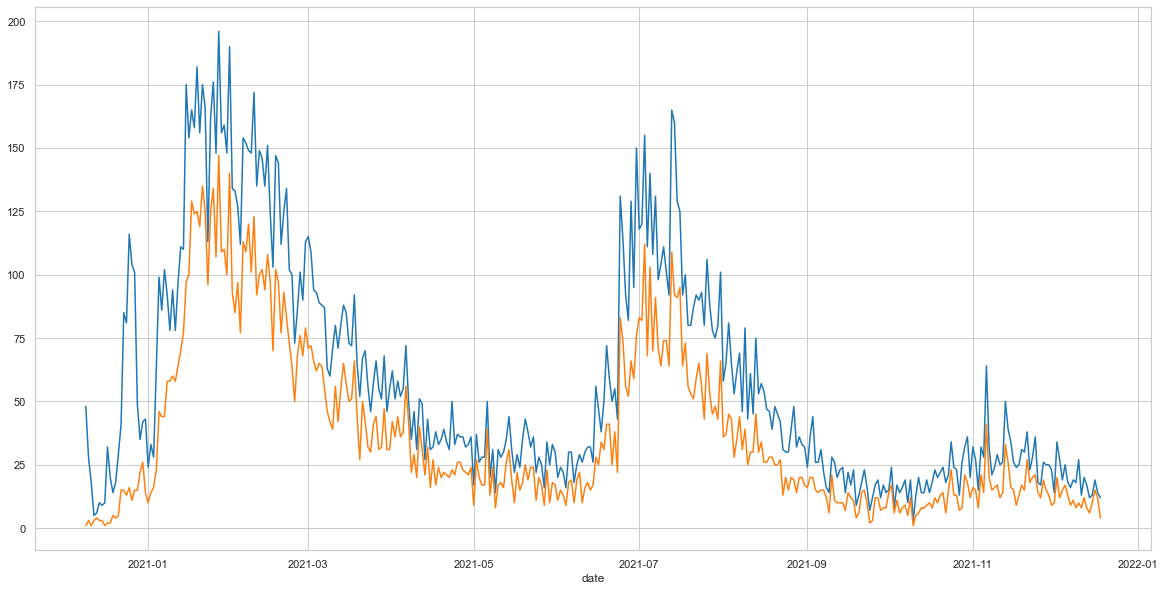

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
df.groupby('date')['id'].count().plot(ax=ax)
_ = df.dropna(subset=["age"]).groupby('date')['age'].count().plot(ax=ax)

In [11]:
df = df.dropna(subset=['age'])
df['age'] = df['age'].astype(int)
df = df.query("5 < age < 100")
# df['sex0'] = df['sex'].map({'М': 1, "Ж": 0})
df = df.reset_index(drop=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13713 entries, 0 to 13712
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       13713 non-null  int64  
 1   date     13713 non-null  object 
 2   from_id  13713 non-null  int64  
 3   message  13713 non-null  object 
 4   time     13713 non-null  object 
 5   sex      13713 non-null  object 
 6   age      13713 non-null  int32  
 7   BAU/ml   454 non-null    float64
 8   OE/ml    417 non-null    float64
 9   AU/ml    105 non-null    float64
 10  ед/мл    227 non-null    float64
 11  Score    993 non-null    float64
dtypes: float64(5), int32(1), int64(2), object(4)
memory usage: 1.2+ MB


In [13]:
df.dropna(subset=scores_cols, how='all')

,id,date,from_id,message,time,sex,age,BAU/ml,OE/ml,AU/ml,ед/мл,Score
122,2673,2020-12-28,187777622,"М34, первая вакцина 07.12 вечером, на след. де...",07:36:58,М,34,NaN,NaN,NaN,400.0,57.142857
213,3852,2021-01-02,642901826,"Ж43, v1 - 28.12 (в 16.00) После вакцинации чер...",11:43:30,Ж,43,NaN,NaN,NaN,17.0,2.428571
249,4713,2021-01-04,152211786,"Ж46, V1 30.12\nТолько немного болело плечо и л...",15:52:46,Ж,46,NaN,NaN,NaN,10.0,1.428571
445,7308,2021-01-08,47086537,"М, 30. V1 - 08.01.21 - введение дозы 12:40, в ...",21:35:00,М,30,NaN,369.0,NaN,NaN,959.400000
509,7890,2021-01-09,717072527,Ж58. V1 делала 2 января. Без побочных эффектов.,23:00:41,Ж,58,NaN,NaN,NaN,175.0,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
12764,131888,2021-10-13,74607718,"Ж34, тиреотоксикоз, артроз 1 ст, на ГВ, перебо...",04:58:37,Ж,34,NaN,151.0,NaN,NaN,392.600000
12765,131889,2021-10-13,1314617939,"М45, в анамнезе поллиноз, мигрени, гипотония, ...",05:59:54,М,45,41.0,NaN,NaN,NaN,41.000000
12778,131975,2021-10-14,1950510144,"Ж70, не болела. v1 спутник 26.02.2021, кроме б...",17:22:10,Ж,70,332.2,NaN,NaN,2339.0,332.200000
12780,131986,2021-10-15,487592485,"Ж38 сегодня утром V1, весь день слабость, к ве...",00:35:44,Ж,38,946.0,NaN,NaN,NaN,946.000000


In [14]:
df.sex.value_counts(normalize=True)

Ж    0.615839
М    0.384161
Name: sex, dtype: float64

In [15]:
df[df['age'] < 18]

,id,date,from_id,message,time,sex,age,BAU/ml,OE/ml,AU/ml,ед/мл,Score
36,971,2020-12-21,179605718,"Просили писать даже если ничего нет. Пишу, 51 ...",21:45:59,М,13,NaN,NaN,NaN,NaN,NaN
10188,120859,2021-07-12,421534161,#дети #вакцинация #КИ\nМ15 Морозовская больниц...,14:30:39,М,15,NaN,NaN,NaN,NaN,NaN
11681,126458,2021-08-07,251718911,Пишу за ребёнка М6 лет закрыт дома как контакт...,05:36:45,М,6,NaN,NaN,NaN,348.0,49.714286
12399,129920,2021-09-05,421534161,#дети #вакцинация #КИ\nМ15 Морозовская больниц...,09:52:25,М,15,350.0,NaN,NaN,NaN,350.000000
12414,129981,2021-09-06,158638098,#дети #вакцинация\nЖ15\nV1 08.07.2021 Пфайзер....,02:44:40,Ж,15,NaN,NaN,NaN,NaN,NaN
12674,131390,2021-10-01,1202788021,"М17, астма\nБолел ковидом в конце декабря-нача...",22:09:48,М,17,563.1,NaN,NaN,NaN,563.100000
13018,133230,2021-11-02,404324333,М13. Вакцинировался #pfizer\nПервая доза-02.11...,19:46:44,М,13,NaN,NaN,NaN,NaN,NaN
13163,133811,2021-11-10,784235167,"М13, вакцина #pfizer #дети\n1 доза 8.11 первые...",09:40:46,М,13,NaN,NaN,NaN,NaN,NaN
13189,134004,2021-11-12,322828600,"#дети Ж 15 лет, без хронических болезней и осо...",10:49:12,Ж,15,NaN,NaN,NaN,NaN,NaN
13223,134158,2021-11-13,212620743,"#дети Москва\nМ, 14. Спутник М #спутникМ\nV1 1...",20:32:26,М,14,NaN,NaN,NaN,NaN,NaN


In [16]:
df.age.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
age,13713.0,39.554219,13.738876,6.0,30.0,36.0,46.0,94.0


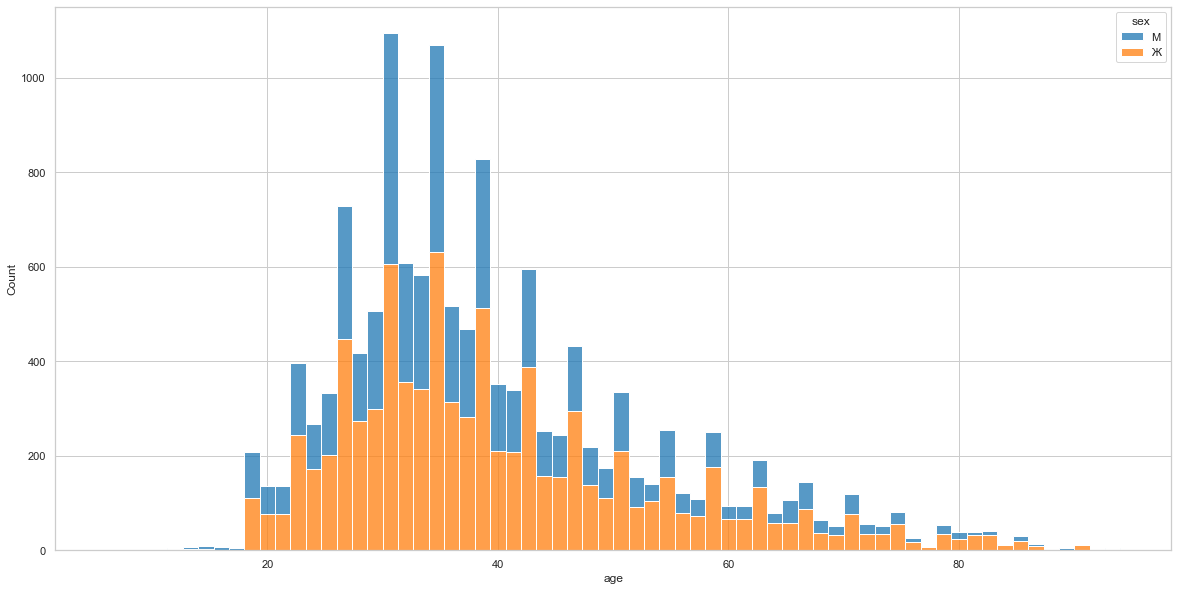

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
_ = sns.histplot(df, x='age', hue='sex', multiple='stack', ax=ax)

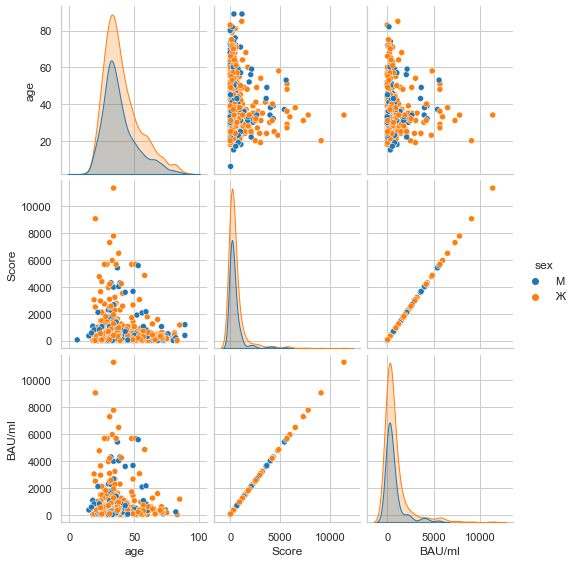

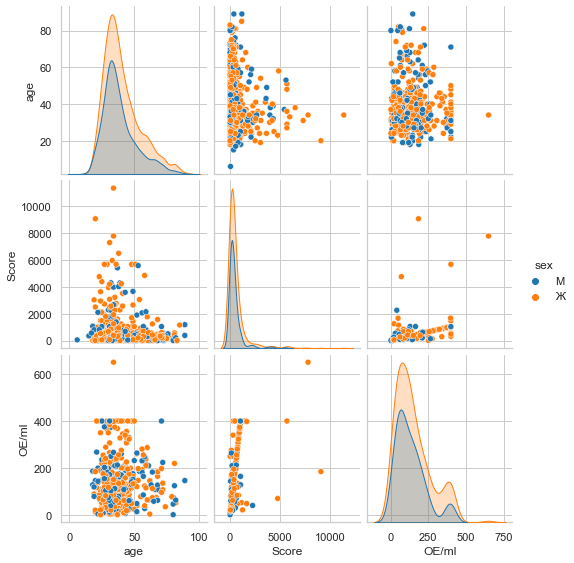

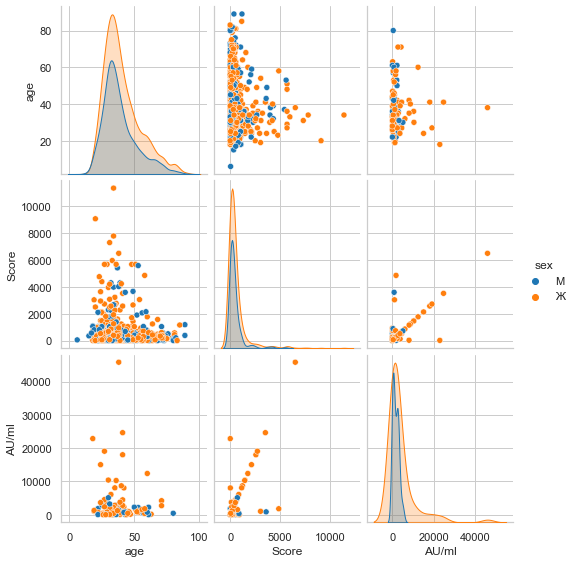

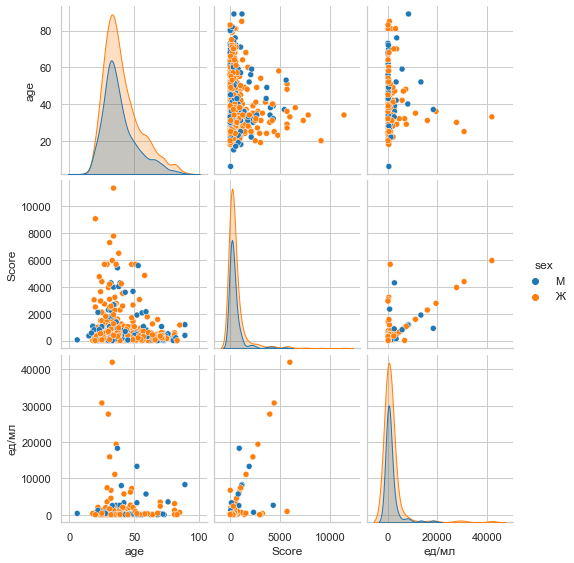

In [22]:
# features = ["Score"] + scores_cols
for feature in scores_cols:
    _ = sns.pairplot(df, vars=['age', "Score", feature], hue='sex')
    _.fig.set_size_inches(8, 8)

In [19]:
# print(*df.message.sample(400), sep='\n')

## ML

In [20]:
df = pd.read_feather("../data/messages.feather")
df = df.dropna(subset=['age'])
df['age'] = df['age'].astype(int)
df = df.query("5 < age < 100")
df = df.reset_index(drop=True)

In [21]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13713 entries, 0 to 13712
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       13713 non-null  int64  
 1   date     13713 non-null  object 
 2   from_id  13713 non-null  int64  
 3   message  13713 non-null  object 
 4   time     13713 non-null  object 
 5   sex      13713 non-null  object 
 6   age      13713 non-null  int32  
 7   BAU/ml   454 non-null    float64
 8   OE/ml    417 non-null    float64
 9   AU/ml    105 non-null    float64
 10  ед/мл    227 non-null    float64
 11  Score    993 non-null    float64
dtypes: float64(5), int32(1), int64(2), object(4)
memory usage: 1.2+ MB


,id,date,from_id,message,time,sex,age,BAU/ml,OE/ml,AU/ml,ед/мл,Score
0,215,2020-12-09,293006292,М37. Первый компонент 03.12.2020 в 17:00. Чере...,23:05:05,М,37,NaN,NaN,NaN,NaN,NaN
1,255,2020-12-10,1200836347,М 48. Без симтомов. Тест на 30 день. вакцина 1...,08:00:09,М,48,NaN,NaN,NaN,NaN,NaN
2,344,2020-12-10,312251578,"Ж34, 9 декабря первая доза, через 3 часа озноб...",22:14:44,Ж,34,NaN,NaN,NaN,NaN,NaN
3,347,2020-12-10,44473357,Ж32. Первая доза 7 декабря. Ночью небольшой оз...,22:46:58,Ж,32,NaN,NaN,NaN,NaN,NaN
4,372,2020-12-11,79373564,"М, 30, первый компонент 8 декабря.\nПобочных э...",13:23:21,М,30,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='age', ylabel='Score'>

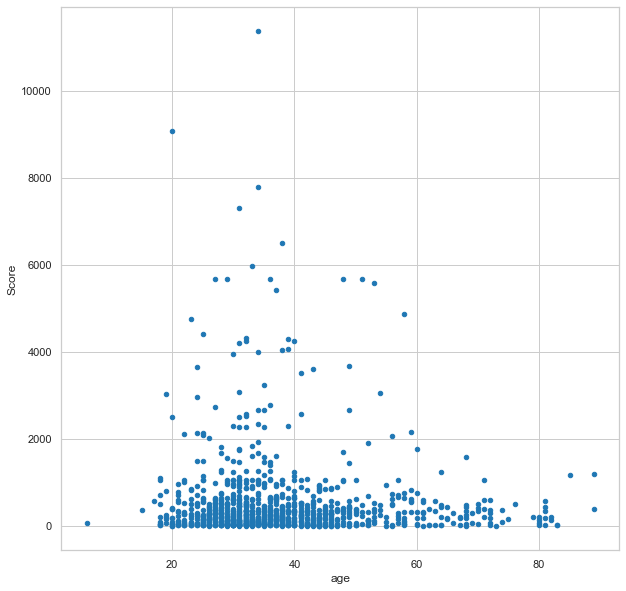

In [26]:
df.plot("age", "Score", kind="scatter", figsize=(10, 10))

In [68]:
df[df.Score < 2000].set_index("age").append(pd.DataFrame([0]*100, index=range(100), columns=['id']))

,id,date,from_id,message,time,sex,BAU/ml,OE/ml,AU/ml,ед/мл,Score
34,2673,2020-12-28,187777622.0,"М34, первая вакцина 07.12 вечером, на след. де...",07:36:58,М,NaN,NaN,NaN,400.0,57.142857
43,3852,2021-01-02,642901826.0,"Ж43, v1 - 28.12 (в 16.00) После вакцинации чер...",11:43:30,Ж,NaN,NaN,NaN,17.0,2.428571
46,4713,2021-01-04,152211786.0,"Ж46, V1 30.12\nТолько немного болело плечо и л...",15:52:46,Ж,NaN,NaN,NaN,10.0,1.428571
30,7308,2021-01-08,47086537.0,"М, 30. V1 - 08.01.21 - введение дозы 12:40, в ...",21:35:00,М,NaN,369.0,NaN,NaN,959.400000
58,7890,2021-01-09,717072527.0,Ж58. V1 делала 2 января. Без побочных эффектов.,23:00:41,Ж,NaN,NaN,NaN,175.0,25.000000
...,...,...,...,...,...,...,...,...,...,...,...
95,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Зависимость антител от возраста

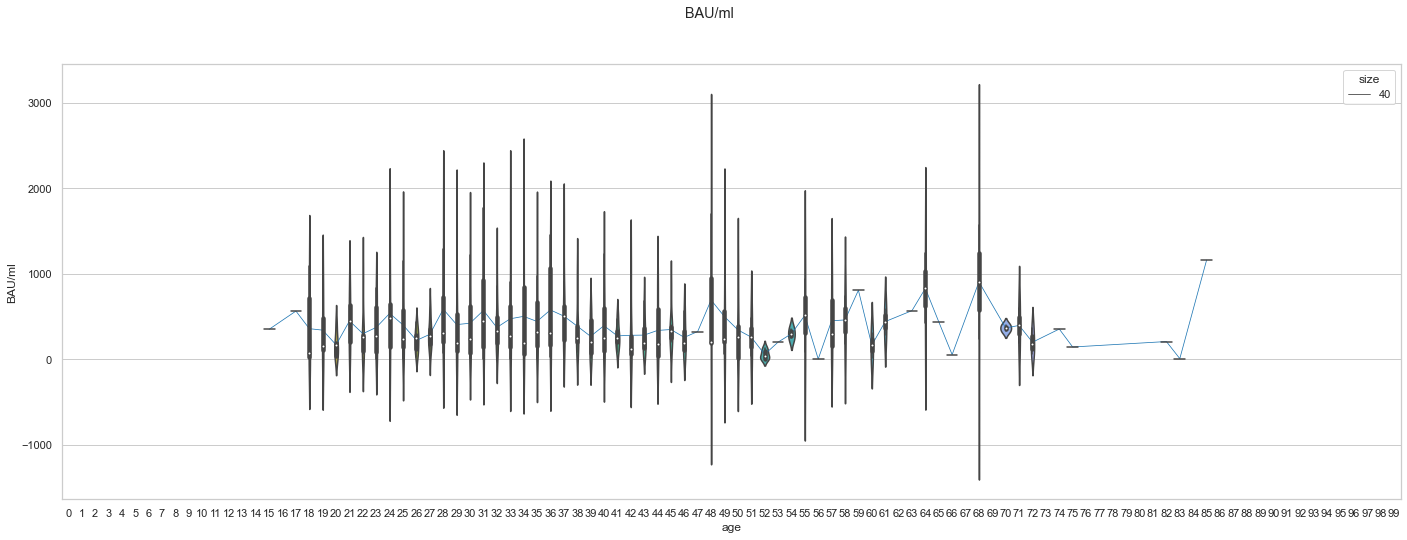

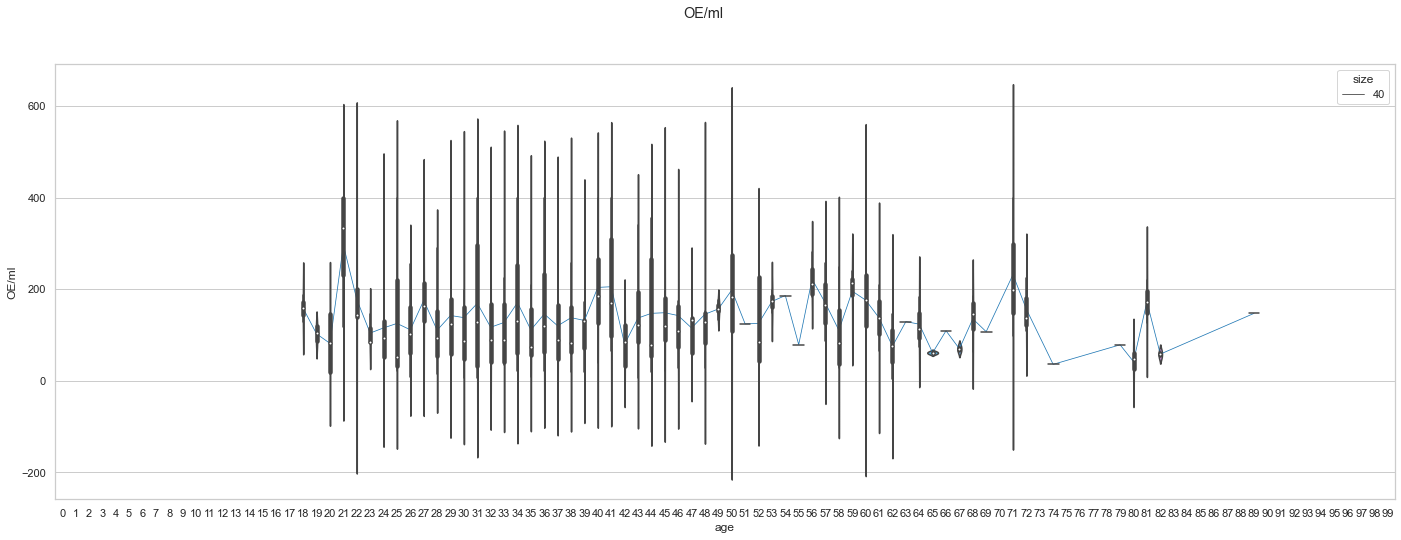

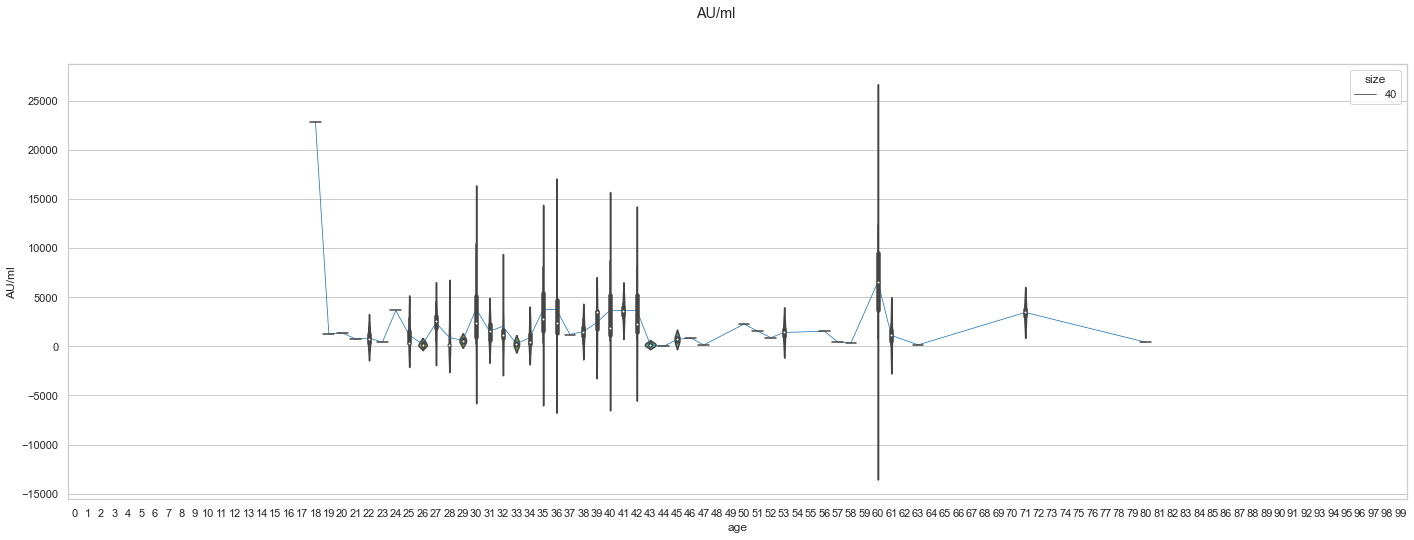

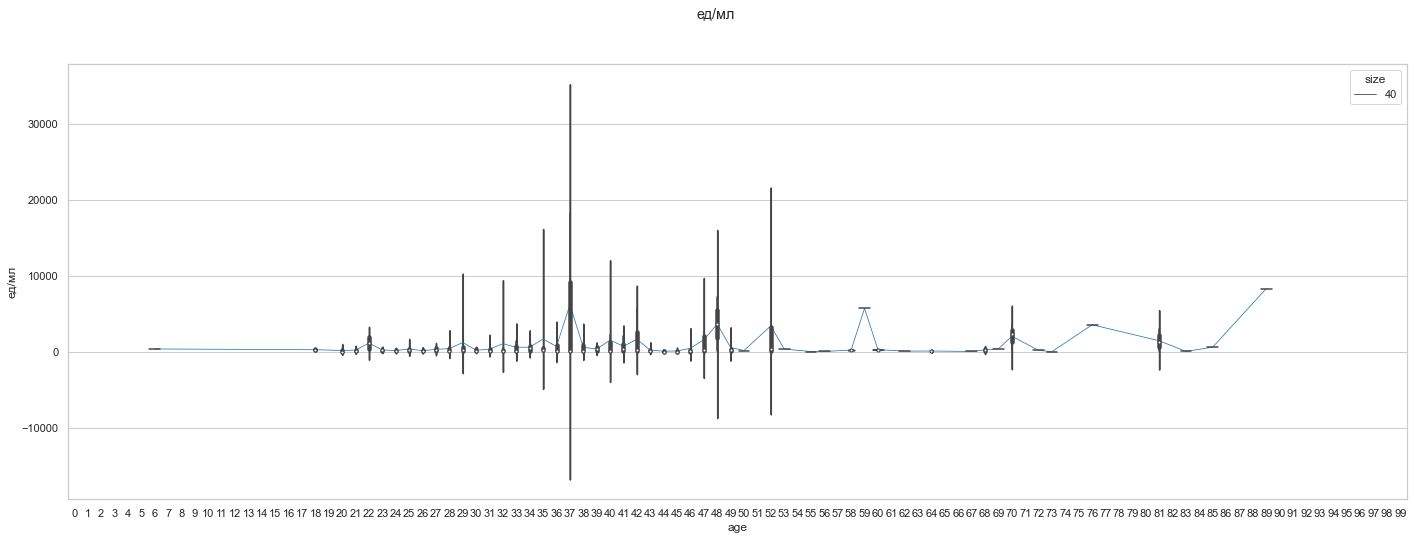

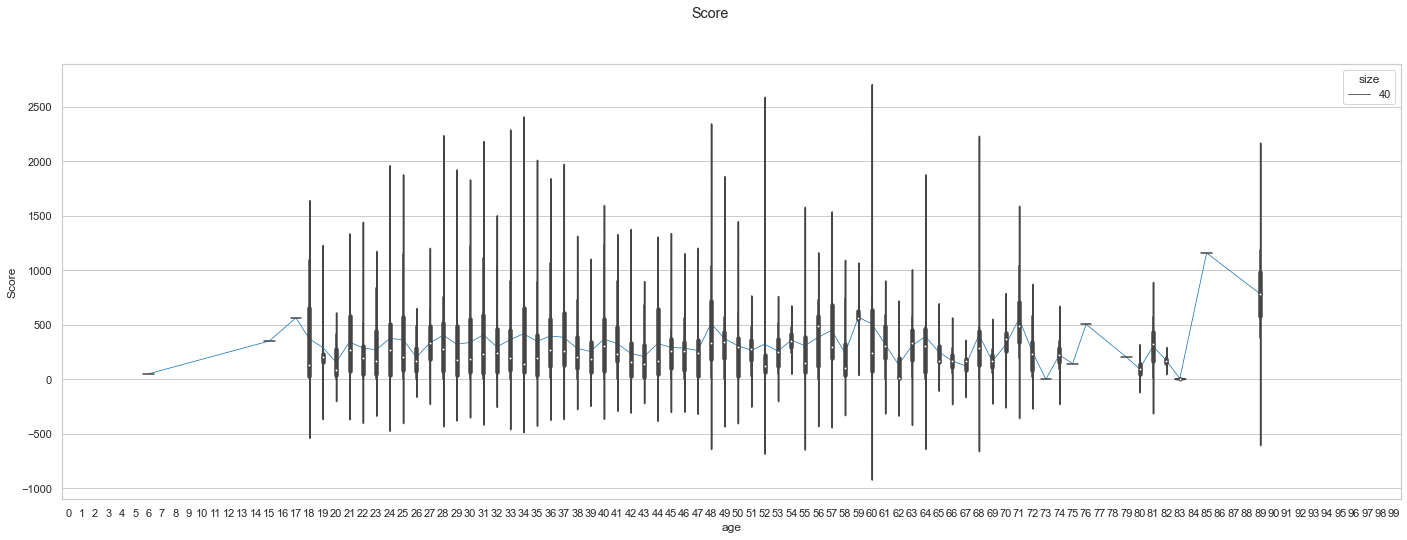

In [86]:
for score_name in ["BAU/ml", "OE/ml", "AU/ml", "ед/мл", "Score"]:
    tmp = df[df.Score < 2000].set_index("age").append(pd.DataFrame([0]*100, index=pd.Series(range(100), name='age'), columns=['id'])).reset_index()
    means = tmp.groupby("age")[[score_name]].mean().reindex(range(6, 100)).reset_index()
    means['size'] = 40
    fig, ax = plt.subplots(figsize=(24, 8))
    sns.lineplot(data=means, y=score_name, x="age", size="size", ax=ax)
    sns.violinplot(data=tmp, y=score_name, x="age", ax=ax)
    fig.suptitle(score_name)